# Schedule changes over time

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os

## Cleaning and pre-processing

### Let's consider, calendar stop_times, trips and routes table

##### We join them and then we clean

##### Merge the datasets accordingly

In [2]:
import os
import pandas as pd

def load_cleaned_data(base_dir, years, seasons):
    # Column definitions
    calendar_columns = ["service_id", "monday", "tuesday", "wednesday", "thursday", "friday", "saturday", "sunday", "start_date", "end_date"]
    stop_times_columns = ["trip_id", "arrival_time", "departure_time", "stop_id"]
    trips_columns = ["route_id", "service_id", "trip_id", "direction_id"]
    
    # Initialize cleaned data storage
    cleaned_data = {}

    for year in years:
        cleaned_data[year] = {}
        for season in seasons:
            # Define file paths
            calendar_path = os.path.join(base_dir, str(year), f"{season}", "calendar.txt")
            stop_times_path = os.path.join(base_dir, str(year), f"{season}", "stop_times.txt")
            trips_path = os.path.join(base_dir, str(year), f"{season}", "trips.txt")
            routes_path = os.path.join(base_dir, str(year), f"{season}", "routes.txt")

            # Load data
            calendar_df = pd.read_csv(calendar_path, usecols=calendar_columns)
            stop_times_df = pd.read_csv(stop_times_path, usecols=stop_times_columns)
            trips_df = pd.read_csv(trips_path, usecols=trips_columns)
            routes_df = pd.read_csv(routes_path)

            # Clean data
            calendar_df.dropna(inplace=True)
            stop_times_df.dropna(inplace=True)
            trips_df.dropna(inplace=True)

            # Filter for commuter rail routes
            commuter_routes = routes_df[routes_df['route_desc'].str.contains("Commuter Rail", na=False)][['route_id', 'route_desc']]

            # Store cleaned data
            cleaned_data[year][season] = {
                "calendar": calendar_df,
                "stop_times": stop_times_df,
                "trips": trips_df,
                "routes": commuter_routes
            }
    return cleaned_data

# def display_cleaned_data_summary(cleaned_data):
#     """
#     Displays a summary of the cleaned data.
    
#     Parameters:
#         cleaned_data (dict): Nested dictionary containing cleaned data for each year and season.
#     """
#     for year in cleaned_data:
#         print(f"Year: {year}")
#         for season in cleaned_data[year]:
#             print(f"  Season: {season}")
#             print("    Calendar:", cleaned_data[year][season]["calendar"].head())
#             print("    Stop Times:", cleaned_data[year][season]["stop_times"].head())
#             print("    Trips:", cleaned_data[year][season]["trips"].head())
#             print("    Routes:", cleaned_data[year][season]["routes"].head())
#             print("-" * 40)

# Usage
base_dir = "./datasets"
years = [2019, 2020, 2021, 2022, 2023, 2024]
seasons = ["Spring", "Fall", "Summer", "Winter"]

cleaned_data = load_cleaned_data(base_dir, years, seasons)
#display_cleaned_data_summary(cleaned_data)


/var/folders/xf/_sn5vxxj05nfsdm_3mlrbfz00000gn/T/ipykernel_11824/180705399.py:24: DtypeWarning: Columns (0,3) have mixed types. Specify dtype option on import or set low_memory=False.
  stop_times_df = pd.read_csv(stop_times_path, usecols=stop_times_columns)
/var/folders/xf/_sn5vxxj05nfsdm_3mlrbfz00000gn/T/ipykernel_11824/180705399.py:24: DtypeWarning: Columns (0,3) have mixed types. Specify dtype option on import or set low_memory=False.
  stop_times_df = pd.read_csv(stop_times_path, usecols=stop_times_columns)
/var/folders/xf/_sn5vxxj05nfsdm_3mlrbfz00000gn/T/ipykernel_11824/180705399.py:24: DtypeWarning: Columns (0,3) have mixed types. Specify dtype option on import or set low_memory=False.
  stop_times_df = pd.read_csv(stop_times_path, usecols=stop_times_columns)
/var/folders/xf/_sn5vxxj05nfsdm_3mlrbfz00000gn/T/ipykernel_11824/180705399.py:24: DtypeWarning: Columns (0,3) have mixed types. Specify dtype option on import or set low_memory=False.
  stop_times_df = pd.read_csv(stop_time

##### Keep only those rows that have route_desc as Commuter Rail

In [3]:
def merge_cleaned_data(cleaned_data):
    """
    Merges cleaned calendar, trips, stop_times, and routes datasets for all years and seasons.
    
    Parameters:
        cleaned_data (dict): Nested dictionary containing cleaned data for each year and season.
    
    Returns:
        dict: Nested dictionary containing merged data for each year and season.
    """
    merged_data = {}

    for year in cleaned_data:
        merged_data[year] = {}
        for season in cleaned_data[year]:
            # Extract individual DataFrames
            calendar_df = cleaned_data[year][season]["calendar"]
            trips_df = cleaned_data[year][season]["trips"]
            stop_times_df = cleaned_data[year][season]["stop_times"]
            commuter_routes = cleaned_data[year][season]["routes"]

            # Merge the datasets
            merged_calendar_trips = pd.merge(trips_df, calendar_df, on='service_id')
            merged_full = pd.merge(merged_calendar_trips, stop_times_df, on='trip_id')
            merged_final = pd.merge(merged_full, commuter_routes, on='route_id', how='inner')

            # Store the merged data
            merged_data[year][season] = merged_final

    return merged_data

merged_data = merge_cleaned_data(cleaned_data)

In [4]:
def filter_commuter_rail_data(merged_data, target_desc='Commuter Rail'):
    """
    Filters merged data to keep only rows related to the specified route description.
    
    Parameters:
        merged_data (dict): Nested dictionary containing merged data for each year and season.
        target_desc (str): Description of the routes to filter (default is 'Commuter Rail').
    
    Returns:
        dict: Nested dictionary containing filtered data for each year and season.
    """
    for year in merged_data:
        for season in merged_data[year]:
            merged_df = merged_data[year][season]
            # Filter rows based on route description
            filtered_df = merged_df[merged_df['route_desc'] == target_desc]
            merged_data[year][season] = filtered_df

    return merged_data

filtered_merged_data = filter_commuter_rail_data(merged_data)

In [5]:
# filtered_merged_data[2020]["Spring"]

## Analysis of the schedule change over time

### 1. Train frequency analysis

In [6]:
def calculate_trip_frequency(merged_data):
    # Initialize a list to store frequency data
    frequency_data = []

    # Loop through each year and season in the merged_data
    for year in merged_data:
        for season in merged_data[year]:
            season_df = merged_data[year][season]
            
            # Calculate the unique trip count for the current season
            unique_trip_count = season_df['trip_id'].nunique()
            
            # Append the data as a dictionary
            frequency_data.append({
                'year': year,
                'season': season,
                'unique_trip_count': unique_trip_count
            })

    # Create a DataFrame from the frequency data
    frequency_df = pd.DataFrame(frequency_data)
    
    # Optionally, sort the DataFrame by year and season for better readability
    frequency_df.sort_values(by=['year', 'season'], inplace=True)

    return frequency_df

# Usage example:
frequency_df = calculate_trip_frequency(merged_data)
#print("Train Frequency Analysis (Unique Trip Counts) by Season-Year:")
#print(frequency_df)


##### A line plot showing the number of unique trips per year

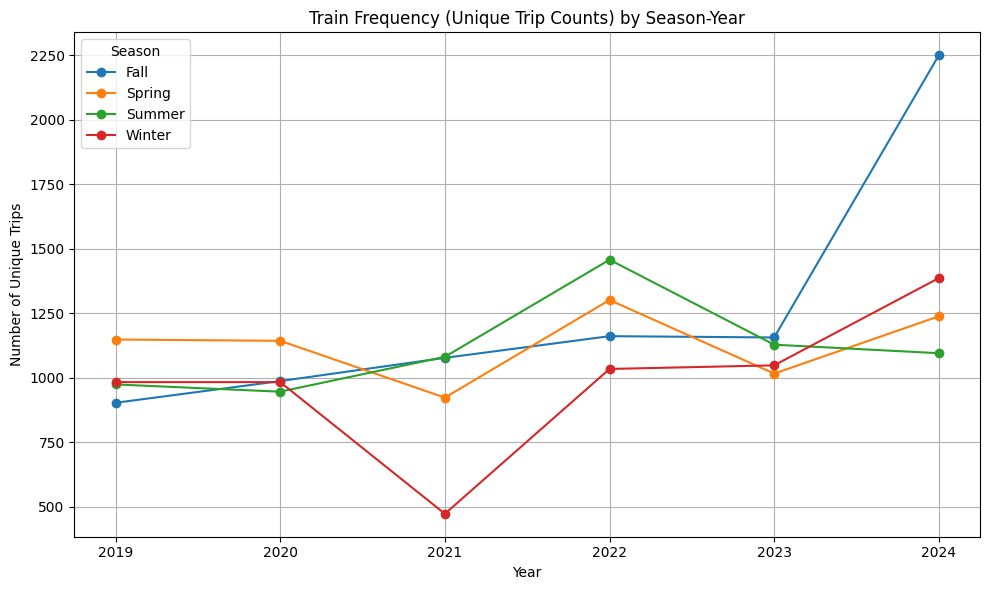

In [7]:
def plot_trip_frequency(merged_data):
    
    # Calculate trip frequency using the previous function
    frequency_df = calculate_trip_frequency(merged_data)

    # Pivot the DataFrame for plotting, with years as rows and seasons as columns
    pivot_df = frequency_df.pivot(index='year', columns='season', values='unique_trip_count')

    # Plot the pivot table
    pivot_df.plot(kind='line', marker='o', figsize=(10, 6))
    plt.title("Train Frequency (Unique Trip Counts) by Season-Year")
    plt.xlabel("Year")
    plt.ylabel("Number of Unique Trips")
    plt.legend(title="Season")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Usage example:
plot_trip_frequency(merged_data)


### 2. How does the trip duration for a given route change through season-year

####  1. Find average trip duration for a given season year

In [8]:
def calculate_average_departure_times(merged_data):
    """
    Calculates the average departure time in minutes past midnight for each year and season.
    
    Parameters:
        merged_data (dict): Nested dictionary containing merged data for each year and season.
    
    Returns:
        pd.DataFrame: DataFrame showing the average departure times by year and season.
    """
    average_departure_times = {}

    for year in merged_data:
        average_departure_times[year] = {}
        for season in merged_data[year]:
            # Get the data for the specific year and season
            season_df = merged_data[year][season].copy()

            # Convert 'departure_time' to datetime and drop invalid entries
            season_df['departure_datetime'] = pd.to_datetime(
                season_df['departure_time'], format='%H:%M:%S', errors='coerce'
            )
            season_df = season_df.dropna(subset=['departure_datetime'])

            # Calculate minutes past midnight for departure times
            season_df['minutes_past_midnight'] = (
                season_df['departure_datetime'].dt.hour * 60
                + season_df['departure_datetime'].dt.minute
            )

            # Calculate the average departure time in minutes past midnight
            avg_departure_minutes = season_df['minutes_past_midnight'].mean()

            # Store the result in the dictionary
            average_departure_times[year][season] = avg_departure_minutes

    # Convert the dictionary to a DataFrame
    avg_departure_df = pd.DataFrame(average_departure_times).T

    return avg_departure_df

# Usage Example
average_departure_df = calculate_average_departure_times(filtered_merged_data)
# print("Average Departure Time by Season-Year (in minutes past midnight):")
# print(average_departure_df)


#### 2. Group data by route and trip id and find the duration of each trip
#### Calculate the average trip duration for each route
#### Calculate the average time duration of a route for season-year

In [9]:
def clean_time_data(df):
    def is_valid_time(time_str):
        try:
            pd.to_datetime(time_str, format='%H:%M:%S')
            return True
        except ValueError:
            return False

    valid_arrival = df['arrival_time'].apply(is_valid_time)
    valid_departure = df['departure_time'].apply(is_valid_time)
    df = df[valid_arrival & valid_departure]
    return df

def calculate_trip_durations(df):
    df = clean_time_data(df)
    df['arrival_time'] = pd.to_datetime(df['arrival_time'], format='%H:%M:%S')
    df['departure_time'] = pd.to_datetime(df['departure_time'], format='%H:%M:%S')
    grouped = df.groupby(['route_id', 'trip_id']).apply(
        lambda x: x['departure_time'].iloc[-1] - x['arrival_time'].iloc[0]
    ).reset_index(name='trip_duration')
    return grouped

def calculate_average_trip_duration_per_route(trip_durations):
    average_durations = trip_durations.groupby('route_id')['trip_duration'].mean().reset_index()
    average_durations.rename(columns={'trip_duration': 'average_trip_duration'}, inplace=True)
    return average_durations

route_data = {}

for year, seasons in merged_data.items():
    for season, df in seasons.items():
        trip_durations = calculate_trip_durations(df)
        average_trip_durations = calculate_average_trip_duration_per_route(trip_durations)

        season_year = f"{season}{year}"
        
        for _, row in average_trip_durations.iterrows():
            route_id = row['route_id']
            avg_duration = row['average_trip_duration']
            
            if route_id not in route_data:
                route_data[route_id] = []
            
            route_data[route_id].append({
                'season-year': season_year,
                'average_trip_duration': avg_duration
            })

route_dfs = {}
for route_id, data in route_data.items():
    route_dfs[route_id] = pd.DataFrame(data)
    route_dfs[route_id].sort_values(by='season-year', inplace=True)


/var/folders/xf/_sn5vxxj05nfsdm_3mlrbfz00000gn/T/ipykernel_11824/4069730198.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['arrival_time'] = pd.to_datetime(df['arrival_time'], format='%H:%M:%S')
/var/folders/xf/_sn5vxxj05nfsdm_3mlrbfz00000gn/T/ipykernel_11824/4069730198.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['departure_time'] = pd.to_datetime(df['departure_time'], format='%H:%M:%S')
/var/folders/xf/_sn5vxxj05nfsdm_3mlrbfz00000gn/T/ipykernel_11824/4069730198.py:18: DeprecationWarnin

In [10]:
# # Replace 'CR-Fairmount' with the route_id you want to view
# route_id_to_view = 'CR-Fairmount'

# # Check if the route_id exists in the route_dfs dictionary
# if route_id_to_view in route_dfs:
#     # Display the DataFrame for the specified route
#     print(route_dfs[route_id_to_view])
# else:
#     print(f"No data found for route ID: {route_id_to_view}")


In [11]:
def combine_route_data(route_dfs):
    # Initialize an empty list to store the data for all routes
    combined_route_data = []

    # Loop through each route in the route_dfs dictionary
    for route_id, data in route_dfs.items():
        # Add the route name column to the data
        data['route_name'] = route_id

        # Convert the trip duration to minutes
        data['average_trip_duration_minutes'] = data['average_trip_duration'].dt.total_seconds() / 60.0

        # For each route, append the data to the combined list
        combined_route_data.append(data[['route_name', 'season-year', 'average_trip_duration_minutes']])

    # Concatenate all the route data into one DataFrame
    combined_df = pd.concat(combined_route_data, ignore_index=True)

    # Sort the data by route_name and season-year
    combined_df.sort_values(by=['route_name', 'season-year'], inplace=True)

    return combined_df

# Usage example:
combined_df = combine_route_data(route_dfs)
#print(combined_df)


In [12]:
import os

def save_dataframe_to_csv(df, file_name, file_path):
    # Ensure the directory exists
    os.makedirs(file_path, exist_ok=True)

    # Create the full file path
    full_path = os.path.join(file_path, file_name)

    # Save the DataFrame as a CSV file
    df.to_csv(full_path, index=False)

    print(f"File saved successfully at: {full_path}")

# Example usage:
file_name = "combined_route_data.csv"
file_path = "/Users/sumanthkamath/Documents/VS Code /DS-701/Project/"  
save_dataframe_to_csv(combined_df, file_name, file_path)


File saved successfully at: /Users/sumanthkamath/Documents/VS Code /DS-701/Project/combined_route_data.csv


#### 5. Plots for each route which shows the change in duration through season-year

This Compares the change in duration for a given line though season year. Hence providing 14 different plots, one for each route. This shows the duration change for all 14 lines in one graph throughout all season-years.

/var/folders/xf/_sn5vxxj05nfsdm_3mlrbfz00000gn/T/ipykernel_11824/2738999239.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab20', num_routes)  # Using the 'tab20' colormap for distinct colors


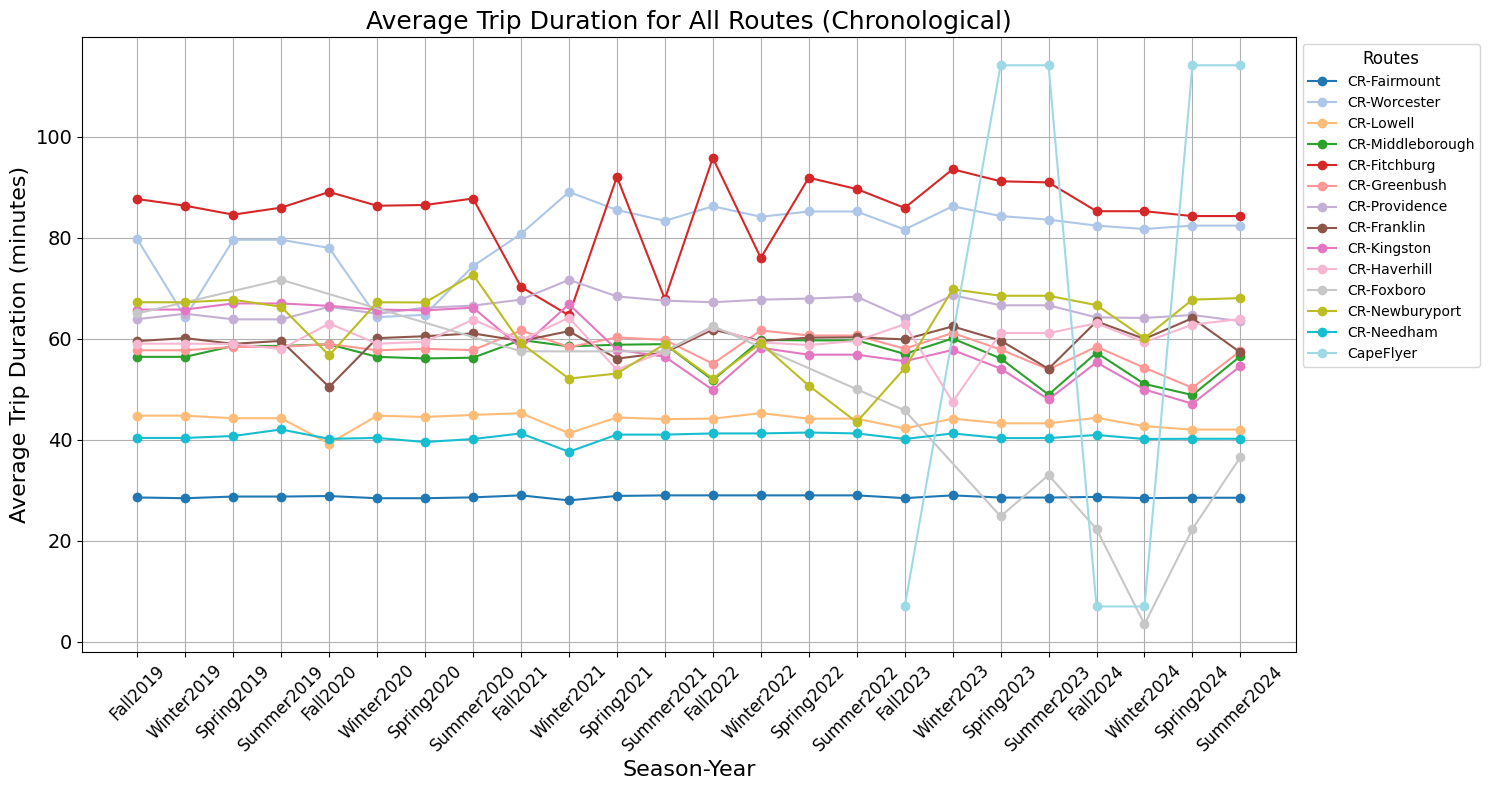

In [13]:
def plot_all_routes_chronological(df):
    # Split the `season-year` column into `season` and `year`
    df['season'] = df['season-year'].str[:-4]  
    df['year'] = df['season-year'].str[-4:]  

    # Define a custom order for the seasons
    season_order = ["Fall", "Winter", "Spring", "Summer"]
    
    # Create a custom sorting key: first by year, then by the season order
    df['season_rank'] = df['season'].map({season: i for i, season in enumerate(season_order)})
    df['sort_key'] = df['year'] + df['season_rank'].astype(str)  
    df = df.sort_values(by=['sort_key']) 

    # Combine `season` and `year` into properly formatted labels for the x-axis
    df['season-year-clean'] = df['season'] + df['year'] 

    # Start plotting
    plt.figure(figsize=(15, 8))
    
    # Generate a unique color for each route using a colormap
    unique_routes = df['route_name'].unique()
    num_routes = len(unique_routes)
    colors = cm.get_cmap('tab20', num_routes)  # Using the 'tab20' colormap for distinct colors
    
    # Plot a line for each route
    for i, route_id in enumerate(unique_routes):
        route_df = df[df['route_name'] == route_id]
        plt.plot(route_df['season-year-clean'], 
                 route_df['average_trip_duration_minutes'], 
                 marker='o', 
                 label=route_id, 
                 color=colors(i))  # Assign a unique color
    
    # Formatting the plot
    plt.title("Average Trip Duration for All Routes (Chronological)", fontsize=18)
    plt.xlabel("Season-Year", fontsize=16)
    plt.ylabel("Average Trip Duration (minutes)", fontsize=16)
    plt.xticks(rotation=45, fontsize=12)  
    plt.yticks(fontsize=14)  
    
    # Move the legend outside the plot or to a better position
    plt.legend(
        title="Routes", 
        fontsize=10, 
        title_fontsize=12, 
        loc='upper left', 
        bbox_to_anchor=(1, 1) 
    )
    plt.grid()
    
    # Ensure layout doesn't cut off labels
    plt.tight_layout()
    
    # Show the plot
    plt.show()

# Call the function with your DataFrame
plot_all_routes_chronological(combined_df)
